<a href="https://colab.research.google.com/github/IvanKatorgin/Feature-Engineering/blob/main/%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%D1%81_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B0%D0%BC%D0%B8_%D0%B8_%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Работа с признаками и построение моделей". Домашнее задание 3. Оценка точности модели, переобучение, регуляризация. Каторгин И.П.

## Описание задания

Решить задачу классификации при помощи обучения модели логистической регрессии. Качество модели оценивается путем подсчета метрик TPR, FPR и построения графиков ROC-кривой, Precision-Recall. Данные для обучения модели хранятся в файле athletes.csv, который можно найти в материалах к занятию.

Этапы работы:
1. Преобразуйте данные:

а. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;

b. закодируйте категориальные переменные числовыми значениями по необходимости.
2. Разделите выборку на обучающее (80% данных) и тестовое (20% данных) подмножества.
3. Постройте ROC-кривую с помощью функции sklearn.metrics. roc_curve.
4. Вычислите значение ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score.
5. Реализуйте подсчет метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn.
6. Постройте ROC-кривую с помощью вычисленных в п. 5 метрик: объедините графики из п. 3 и п. 6 в один. Сравните, сделайте вывод.
7. Постройте график Precision-Recall, используя метрики, посчитанные в п. 5.
8. *Вычислите значение ROC-AUC метрики, используя метрики, посчитанные в п. 5.
9. Сформулируйте выводы по проделанной работе:

a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

b. *может ли ROC-кривая проходить ниже диагонали?

## Загрузка и разведочный анализ данных, поиск выбросов

In [311]:
# загрузим необходимые библиотеки
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib import colors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

Первоначально проведем разведочный анализ данных и проверим данные на выбросы

In [312]:
# загрузим данные
athletes = pd.read_csv('athletes.csv', sep=',', encoding='utf8')
athletes

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


In [313]:
athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [314]:
athletes.describe()

,id,height,weight,gold,silver,bronze
count,1.153800e+04,11208.000000,10879.000000,11538.000000,11538.000000,11538.000000
mean,4.999885e+08,1.766282,72.068205,0.057722,0.056769,0.061016
std,2.908648e+08,0.112719,16.177334,0.255910,0.239147,0.243320
min,1.834700e+04,1.210000,31.000000,0.000000,0.000000,0.000000
25%,2.450997e+08,1.690000,60.000000,0.000000,0.000000,0.000000
50%,5.002011e+08,1.760000,70.000000,0.000000,0.000000,0.000000
75%,7.539874e+08,1.840000,81.000000,0.000000,0.000000,0.000000
max,9.999878e+08,2.210000,170.000000,5.000000,2.000000,2.000000


In [315]:
athletes[['nationality']].value_counts()

,count
nationality,
USA,567
BRA,485
GER,441
AUS,431
FRA,410
...,...
DMA,2
SOM,2
GEQ,2


In [316]:
athletes[['sex']].value_counts()

,count
sex,
male,6333
female,5205


In [317]:
athletes[['height']].value_counts()

,count
height,
1.80,580
1.70,579
1.75,484
1.78,453
1.73,424
...,...
1.42,1
1.40,1
1.38,1


In [318]:
athletes[['weight']].value_counts()

,count
weight,
70.0,482
60.0,387
65.0,382
75.0,342
58.0,336
...,...
146.0,1
133.0,1
134.0,1


In [319]:
athletes[['sport']].value_counts()

,count
sport,
athletics,2363
aquatics,1445
football,611
rowing,547
cycling,525
hockey,432
judo,392
shooting,390
volleyball,384


In [320]:
athletes[['gold']].value_counts()

,count
gold,
0,10919
1,584
2,27
3,5
4,2
5,1


In [321]:
athletes[['silver']].value_counts()

,count
silver,
0,10904
1,613
2,21


In [322]:
athletes[['bronze']].value_counts()

,count
bronze,
0,10845
1,682
2,11


In [323]:
# посмотрим на данные графически

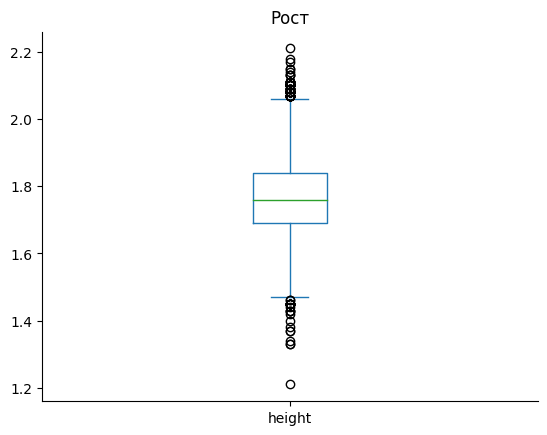

In [324]:
# @title Боксплот по росту

from matplotlib import pyplot as plt
athletes['height'].plot(kind='box', title='Рост')
plt.gca().spines[['top', 'right',]].set_visible(False)

Аномально высокий рост - скорее всего баскетболисты, аномально низкий - возможно женщины

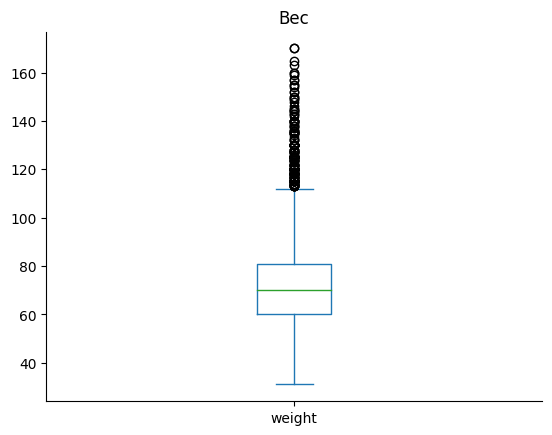

In [325]:
# @title Боксплот по весу

from matplotlib import pyplot as plt
athletes['weight'].plot(kind='box', title='Вес')
plt.gca().spines[['top', 'right',]].set_visible(False)

Аномально высокий вес возможно связан со специфическими видами спорта, возможно тяжелая атлетика

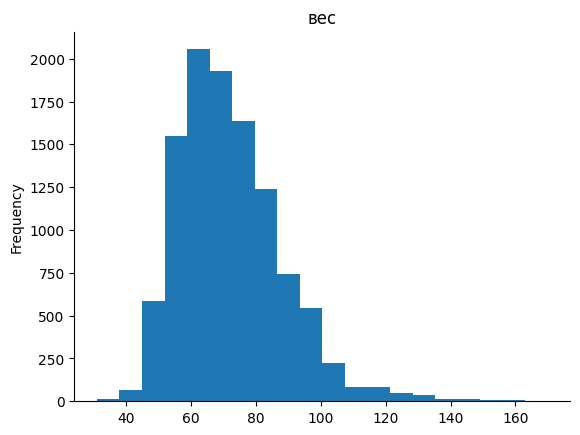

In [326]:
# @title Распределение веса

from matplotlib import pyplot as plt
athletes['weight'].plot(kind='hist', bins=20, title='вес')
plt.gca().spines[['top', 'right',]].set_visible(False)

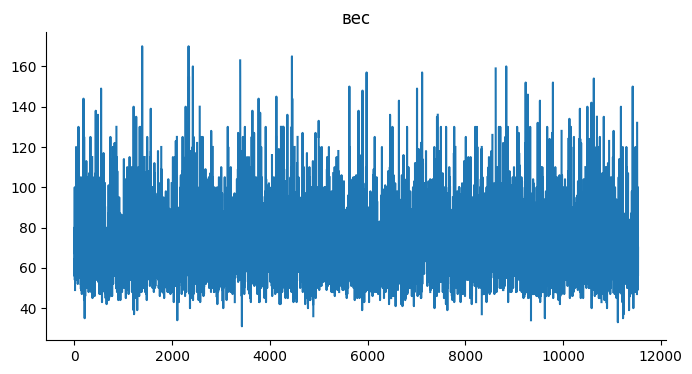

In [327]:
# @title Вес

from matplotlib import pyplot as plt
athletes['weight'].plot(kind='line', figsize=(8, 4), title='вес')
plt.gca().spines[['top', 'right']].set_visible(False)

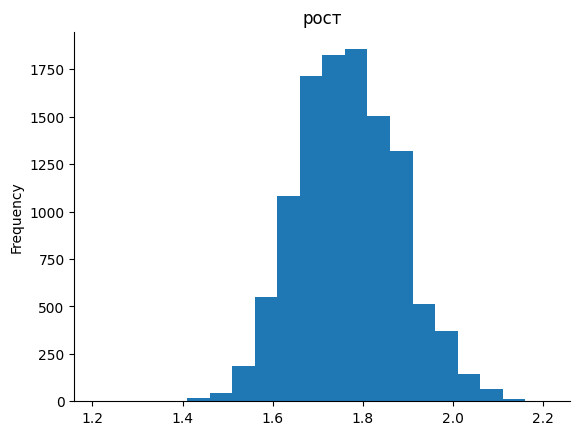

In [328]:
# @title Распределение роста

from matplotlib import pyplot as plt
athletes['height'].plot(kind='hist', bins=20, title='рост')
plt.gca().spines[['top', 'right',]].set_visible(False)

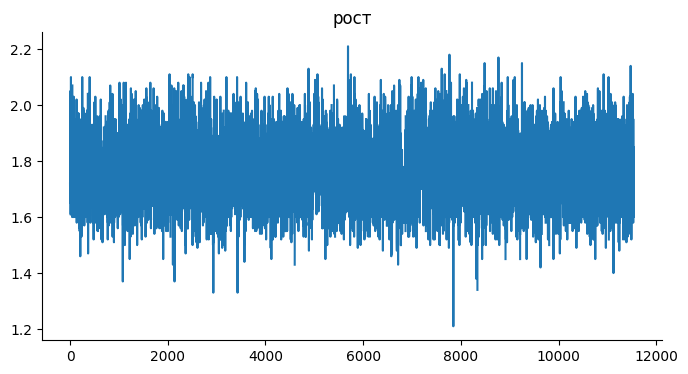

In [329]:
# @title Рост

from matplotlib import pyplot as plt
athletes['height'].plot(kind='line', figsize=(8, 4), title='рост')
plt.gca().spines[['top', 'right']].set_visible(False)

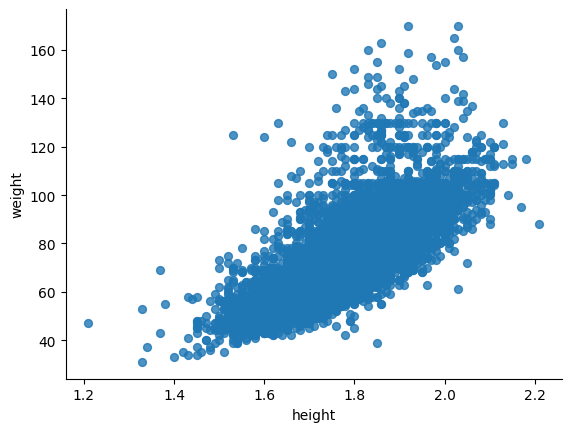

In [330]:
# @title Соотношение роста и веса

from matplotlib import pyplot as plt
athletes.plot(kind='scatter', x='height', y='weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-331-5913eb596832>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(athletes, x='weight', y='sex', inner='box', palette='Dark2')


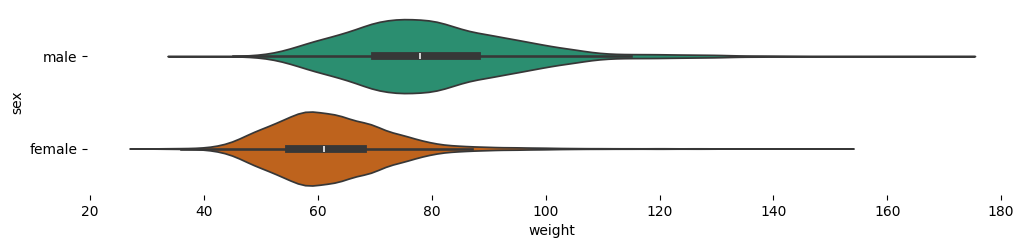

In [331]:
# @title Вес относительно пола

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(athletes['sex'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(athletes, x='weight', y='sex', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-332-2e1553e0f59c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(athletes, x='height', y='sex', inner='box', palette='Dark2')


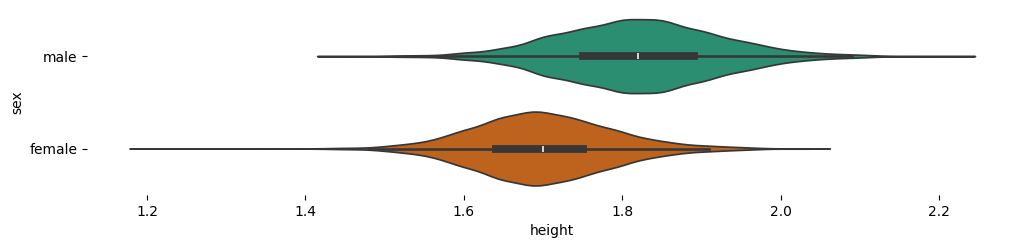

In [332]:
# @title Рост относительно пола

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(athletes['sex'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(athletes, x='height', y='sex', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Основные выводы по разведочному анализу данных:
1. Явных аномалий и выбросов в данных не обнаружено
2. Мужчин в ввыборке больше, чем женщин
3. Распределение роста имеет нормальную кривую
4. Распределение веса имеет логнормальную форму, это связано с тем, что в выборе имеются спортсмены с довольно высоким весом. Точно неизвестно, с чем это связано, возможно имеет место специфицеский вид спорта, например тяжелая атлетика, возможно что-то другое


## 1. Преобразование данных

1. Преобразуйте данные:

а. проверьте наличие пропущенных значений. Преобразуйте/удалите пропуски по необходимости;

b. закодируйте категориальные переменные числовыми значениями по необходимости

In [333]:
# проверим на наличие пропусков
athletes.isna().mean() * 100

,0
id,0.000000
name,0.000000
nationality,0.000000
sex,0.000000
dob,0.008667
height,2.860114
weight,5.711562
sport,0.000000
gold,0.000000
silver,0.000000


In [ ]:
# имеются пропуски в столбцах 'dob', 'height' и 'weight'

In [334]:
# пропуски в столбце 'dob' предлагается удалить, т.к. мы не знаем дату рождения и не можем заполнить ни средним значением, ни медианным, ни соседним
athletes = athletes.dropna(subset=['dob'])

In [335]:
# пропуски в столбце 'height' предлагается заполнить средним значением в зависиомсти от пола, а в столбце 'weight' предлагается заполнить медианным значением в зависиомсти от пола
athletes = athletes.fillna({'height': athletes['height'].median(), 'weight': athletes['weight'].median()})

In [336]:
# для этого исходную выборку раздели на мужскую и женщинскую
athletes_men = athletes[athletes['sex'] == 'male']
athletes_women = athletes[athletes['sex'] == 'female']

In [337]:
# заполним пропуски в столбце 'height' средним значением в зависиомсти от пола
athletes_men = athletes_men.fillna({'height': athletes_men['height'].mean()})
athletes_women = athletes_women.fillna({'height': athletes_women['height'].mean()})

# заполним пропуски в столбце 'weight' медианным значением в зависиомсти от пола
athletes_men = athletes_men.fillna({'weight': athletes_men['weight'].median()})
athletes_women = athletes_women.fillna({'weight': athletes_women['weight'].median()})

In [338]:
# снова объединим обе выборки в одну
athletes = pd.concat([athletes_men, athletes_women])
athletes

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
5,173071782,Aaron Royle,AUS,male,1/26/90,1.80,67.0,triathlon,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11527,738530209,Zsofia Kovacs,HUN,female,2/7/88,1.80,58.0,triathlon,0,0,0
11528,499425013,Zsofia Kovacs,HUN,female,4/6/00,1.58,49.0,gymnastics,0,0,0
11530,739315046,Zsuzsanna Jakabos,HUN,female,4/3/89,1.85,70.0,aquatics,0,0,0
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0


In [339]:
athletes.isna().mean() * 100

,0
id,0.0
name,0.0
nationality,0.0
sex,0.0
dob,0.0
height,0.0
weight,0.0
sport,0.0
gold,0.0
silver,0.0


In [340]:
# попробуем выбрать какие-нибудь признаки
selectedColumns = athletes[['nationality','height', 'weight', 'sport', 'sex', 'gold', 'silver', 'bronze']]

# столбец sport является категориальной переменной
# переведем ее в значения 0 и 1, добавив столбцы с соответствующими названиями
X = pd.get_dummies(selectedColumns, columns = ['sport', 'nationality', 'gold', 'silver', 'bronze'])

# столбец sex является целевой переменной, удаляем его из X
del X['sex']
X.head()

,height,weight,sport_aquatics,sport_archery,sport_athletics,sport_badminton,sport_basketball,sport_boxing,sport_canoe,sport_cycling,...,gold_2,gold_3,gold_4,gold_5,silver_0,silver_1,silver_2,bronze_0,bronze_1,bronze_2
0,1.72,64.0,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
2,1.98,79.0,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
3,1.83,80.0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
4,1.81,71.0,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,False,False
5,1.80,67.0,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False


In [341]:
# целевая переменная (столбец sex) снова является категориальной
# переведем значения столбца в числа, оставив один столбец
le = LabelEncoder()

In [342]:
le.fit(athletes['sex'])

LabelEncoder()

In [343]:
le.classes_

array(['female', 'male'], dtype=object)

In [344]:
# пример "расшировки" столбца sex
le.transform(['male', 'female', 'male'])

array([1, 0, 1])

In [345]:
# записываем в переменную y преобразованный столбец sex
y = pd.Series(data = le.transform(athletes['sex']))
y.head()

,0
0,1
1,1
2,1
3,1
4,1


## 2. Разделение выборки на обучающее (80% данных) и тестовое (20% данных) подмножества. Построение модели логистической регрессии

In [346]:
model = LogisticRegression()

In [347]:
# разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [348]:
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [349]:
predictions = model.predict_proba(X_test)

In [350]:
predictions[:5]

array([[0.48640859, 0.51359141],
       [0.01458814, 0.98541186],
       [0.17568791, 0.82431209],
       [0.96283955, 0.03716045],
       [0.66859551, 0.33140449]])

In [351]:
#считаем accuracy на тренировочной выборке
model.score(X_train, y_train)

0.8298840611117131

In [352]:
#считаем accuracy на тестовой выборке
model.score(X_test, y_test)

0.8158578856152513

## 3. Построение ROC-кривой с помощью функции sklearn.metrics. roc_curve

In [353]:
fpr1, tpr1, thres1 = roc_curve(y_test, predictions[:, 1])

In [354]:
for line in zip(fpr1, tpr1, thres1):
  print( line )

(0.0, 0.0, inf)
(0.0, 0.000794912559618442, 0.9999998363508534)
(0.0, 0.015103338632750398, 0.9997485024083854)
(0.0009523809523809524, 0.015103338632750398, 0.999739440145643)
(0.0009523809523809524, 0.02066772655007949, 0.9993430787311284)
(0.0019047619047619048, 0.02066772655007949, 0.9991798530848855)
(0.0019047619047619048, 0.021462639109697933, 0.9991431897799692)
(0.002857142857142857, 0.021462639109697933, 0.9990770676271681)
(0.002857142857142857, 0.031001589825119236, 0.9975193698284822)
(0.0038095238095238095, 0.031001589825119236, 0.9973727538913894)
(0.0038095238095238095, 0.03815580286168521, 0.996147274800584)
(0.004761904761904762, 0.03815580286168521, 0.9960813038022271)
(0.004761904761904762, 0.046104928457869634, 0.9950950399733014)
(0.005714285714285714, 0.046104928457869634, 0.9950408775091424)
(0.005714285714285714, 0.05246422893481717, 0.9940479324980175)
(0.006666666666666667, 0.05246422893481717, 0.9938912084834011)
(0.006666666666666667, 0.058823529411764705, 

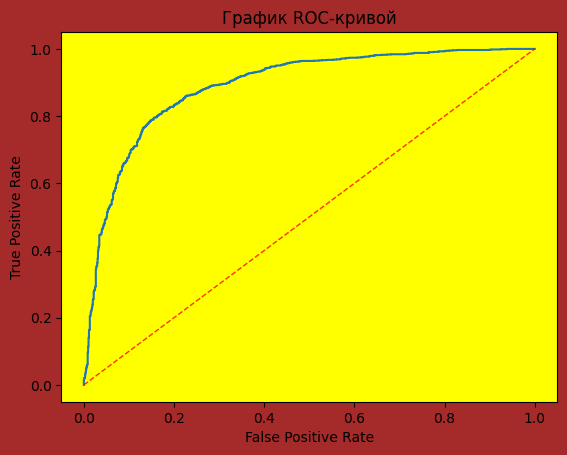

In [355]:
# @title график ROC-кривой

plt.figure(facecolor='brown')
plt.axes().set_facecolor('yellow')
l=np.linspace(0,1)
plt.plot(fpr1, tpr1, label='ROC Curve')
plt.plot(l, l, color = 'red', lw=1, linestyle='--', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой')
plt.show()

## 4. Вычисление значения ROC-AUC метрики с помощью функции sklearn.metrics.roc_auc_score

In [356]:
# вычислим значение roc-auc метрики помощью функции sklearn.metrics.roc_auc_score
roc_auc_score(y_test, predictions[:, 1])

0.8893288666818079

## 5. Реализация подсчета метрик TPR, FPR «вручную», без использования готовых функций из библиотеки sklearn

In [357]:
def metrics(thresh, predictions, y_test):
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative
    for predicted_prob, actual in zip(predictions[:, 1], y_test):
        if predicted_prob >= thresh:
           predicted = 1
        else:
           predicted = 0
        if predicted == 1:
           if actual == 1:
             tp += 1
           else:
             fp += 1
        else:
           if actual == 1:
              fn += 1
           else:
              tn += 1
    return(tp, fp, fn, tn)

In [358]:
fpr = []
tpr = []

In [359]:
for thresh in np.linspace(0,1,100):
 tp, fp, fn, tn = metrics(thresh, predictions, y_test)
 if fp == 0 and tn == 0:
  fpr.append(0)
 else:
  fpr.append(fp/(fp+tn))
 if tp == 0 and fn == 0:
  tpr.append(0)
 else:
  tpr.append(tp/(tp+fn))

## 6. Построение ROC-кривой с помощью вычисленных в п. 5 метрик: объединение графиков из п. 3 и п. 6 в один. Сравнение, выводы

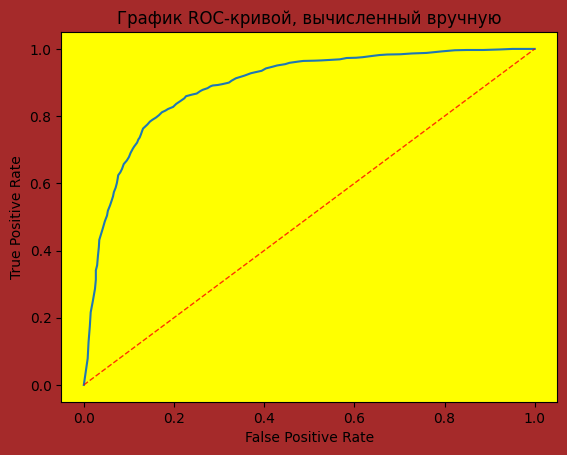

In [360]:
# @title график ROC-кривой, вычисленный вручную

plt.figure(facecolor='brown')
plt.axes().set_facecolor('yellow')
l=np.linspace(0,1)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot(l, l, color = 'red', lw=1, linestyle='--', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой, вычисленный вручную')
plt.show()

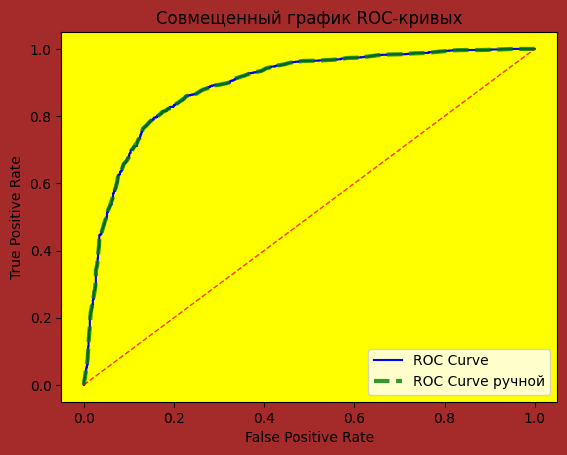

In [361]:
# @title Совмещенный график ROC-кривых

plt.figure(facecolor='brown')
plt.axes().set_facecolor('yellow')
plt.plot(fpr1, tpr1, color = 'blue', label='ROC Curve')
plt.plot(fpr, tpr, color = 'green', lw=3, linestyle='--', alpha=.8, label='ROC Curve ручной')
plt.plot(l, l, color = 'red', lw=1, linestyle='--', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Совмещенный график ROC-кривых')
plt.legend()
plt.show()

In [362]:
# Посчитаем площадь под ROC-кривой
auc(fpr1, tpr1).round(5)

0.88933

In [363]:
# Посчитаем площадь под ROC-кривой для моделей, посчитанной вручную
auc(fpr, tpr).round(5)

0.88926

Выводы:

Визуально графики совпали. Для уточнения были дополнительно посчитаны площади под кривой обоих графиков. По вычисленной площади можно сделать вывод, что площадь ROC-кривой для моделей, посчитанной вручную незначительно меньше, на уровне статистически незначимой погрешности (четвертый знак после запятой)

## 7. Построение графика Precision-Recall, используя метрики, посчитанные в п. 5

In [364]:
pr, re, thres = precision_recall_curve(y_test, predictions[:, 1])

In [365]:
for line in zip(pr, re, thres):
  print(line)

(0.5450606585788561, 1.0, 0.0021152166910939933)
(0.5452969224100563, 1.0, 0.0028864012242294126)
(0.5455333911535126, 1.0, 0.004277654467511531)
(0.545770065075922, 1.0, 0.004539238740199699)
(0.5460069444444444, 1.0, 0.00497405510922587)
(0.5462440295267043, 1.0, 0.0054133882078886844)
(0.5464813205907906, 1.0, 0.005655060518631662)
(0.5467188179052586, 1.0, 0.006190081146512048)
(0.5469565217391305, 1.0, 0.006574390876671138)
(0.5471944323618965, 1.0, 0.006697905428378183)
(0.5474325500435161, 1.0, 0.007212899165846879)
(0.5476708750544188, 1.0, 0.007432119155166594)
(0.5479094076655052, 1.0, 0.007643517532699018)
(0.5481481481481482, 1.0, 0.007712309369783057)
(0.5483870967741935, 1.0, 0.007912434205812821)
(0.5486262538159616, 1.0, 0.007999326567278227)
(0.5488656195462478, 1.0, 0.008518734739017035)
(0.5491051942383238, 1.0, 0.009127688731984024)
(0.5493449781659389, 1.0, 0.00942146343677355)
(0.5495849716033202, 1.0, 0.00998654514626924)
(0.5498251748251748, 1.0, 0.0111120336104

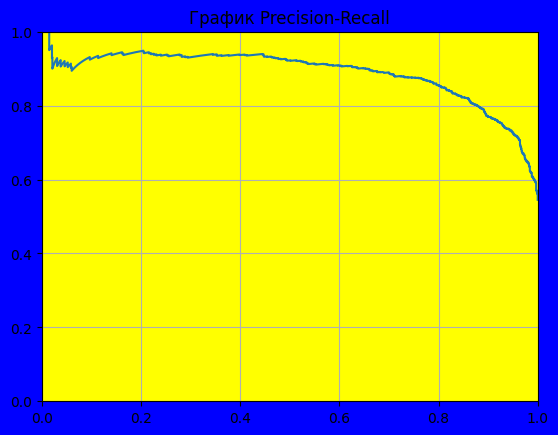

In [366]:
# @title График Precision-Recall

plt.figure(facecolor='blue')
plt.axes().set_facecolor('yellow')
plt.plot(re, pr)
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('График Precision-Recall')
plt.show()

## 8. *Вычисление значения ROC-AUC метрики, используя метрики, посчитанные в п. 5

In [367]:
# вычислим значение ROC-AUC
roc_auc_score(y_test, predictions[:, 1]).round(5)

0.88933

In [368]:
# вычислим значение ROC-AUC с помощью trapz
auc = -np.trapz(tpr,fpr).round(5)
auc

0.88926

## 9. Основные выводы по проделанной работе

a. как по полученным графикам сделать вывод о качестве модели? Как вы оцениваете обученную модель исходя из подсчитанных метрик?

b. *может ли ROC-кривая проходить ниже диагонали?

Основные выводы:
1. Проведен разведочный анализ данных. Выбросов не обнаружено;
2. Пропуски по весу и росту было решено заполнить средними и медианными значениями в зависимости от пола спортсмена;
3. Строка с пропуском в дате рождения была удалена;
4. Построена модель логистической регрессии предсказывающая пол спортсмена в зависимости от выбранных признаков (рост, вес, вид спорта, количество медалей, национальность);
5. Accuracy по тестовой выборке составила 0.815;
6. Проведена оценка точности модели с помощью основных метрик качества;
7. Площадь под roc-кривой составила 0.889;
8. В целом, учитывая высокие значения accuracy и площади под roc-кривой, можно сделать вывод о том, что модель получлась эффективной и довольно точно предсказывает пол спортсмена в зависимости от выбранных признаков.

Выводы по ROC-кривой:
1. Чем ближелощадь кривой к 1, тем тем лучше и выше качество модели. В идеале ROC-кривая будет проходить через верхний левый угол (tpr = 1, fpr = 0), что будет означать высокую чувствительность и низкую частоту ложных срабатываний, что недостижимо в реальном мире;
2. ROC-кривая может проходить ниже диагонали. В таком случае такая кривая указывает на то, что модель делает предсказания, противоположные меткам: низкие предсказанные оценки связаны с меткой, а высокие — нет.